# Geometry plotting

This notebook provides a tutorial for plotting tidy3d components **before** running them, to get a sense for the geometry.

In [1]:
import matplotlib.pylab as plt
import numpy as np

import tidy3d as td

# set logging level to ERROR because we'll only create simulations for demonstration, we're not running them.
td.config.logging_level = "ERROR"


## Simple, 2D plotting

### Geometries

All [Geometry](../_autosummary/tidy3d.components.geometry.Geometry.html) objects, such as [Box](../_autosummary/tidy3d.Box.html), [Sphere](../_autosummary/tidy3d.Sphere.html), [Cylinder](../_autosummary/tidy3d.Cylinder.html), and [PolySlab](../_autosummary/tidy3d.PolySlab.html), have a `.plot()` method that plots their geometries on a plane specified by coordinate=position syntax (eg. `z=5.0`).

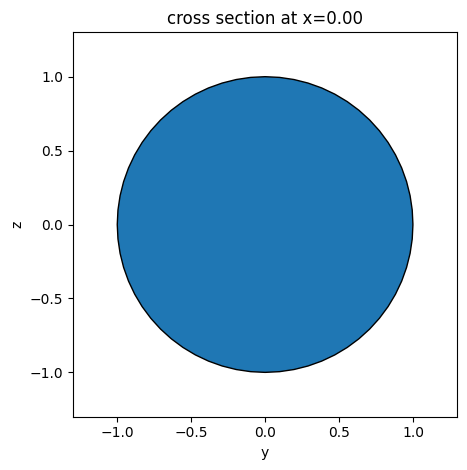

In [2]:
cylinder = td.Cylinder(center=(0, 0, 0), radius=1, length=2, axis=0)
ax = cylinder.plot(x=0)
plt.show()


### Structures

[Structure](../_autosummary/tidy3d.Structure.html) objects, which combine a [Geometry](../_autosummary/tidy3d.components.geometry.Geometry.html) with a [Medium](../_autosummary/tidy3d.components.medium.AbstractMedium.html), work the same way.

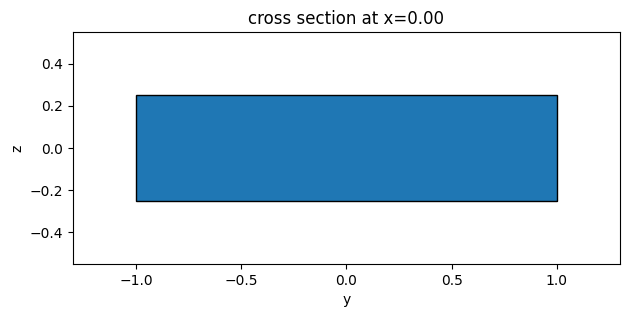

In [3]:
box = td.Structure(
    geometry=td.Box(center=(0.0, 0.0, 0), size=(4, 2.0, 0.5)),
    medium=td.Medium(permittivity=2.0),
)

ax = box.plot(x=0)


We can supply `ax` argument to the plot function to plot on a specific Matplotlib [Axes](https://matplotlib.org/stable/api/axes_api.html), for example

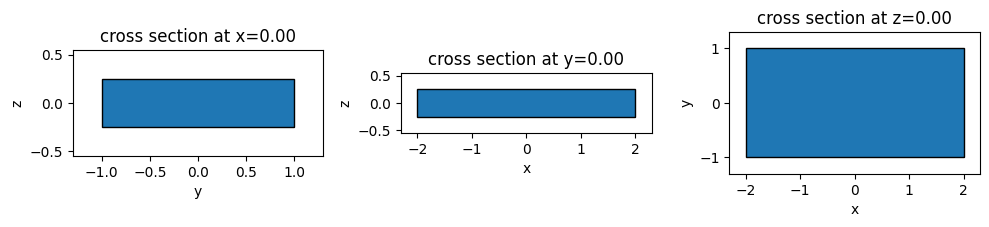

In [4]:
# make 3 columns of axes
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))

# plot each axis of the plot on each subplot
ax1 = box.plot(x=0, ax=ax1)
ax2 = box.plot(y=0, ax=ax2)
ax3 = box.plot(z=0, ax=ax3)


The `.plot()` method returns either a new axis (if ax not supplied) or the orginal axis, so you can add more objects to the plot, or edit it through the `ax` handle.

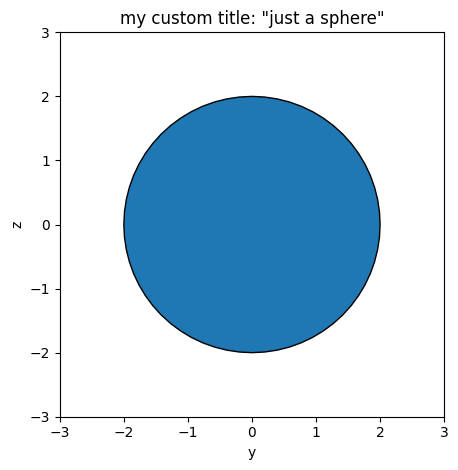

In [5]:
sphere = td.Structure(
    geometry=td.Sphere(center=(0, 0, 0), radius=2), medium=td.Medium(permittivity=3)
)

ax = sphere.plot(x=0)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_title('my custom title: "just a sphere"')
plt.show()


Finally, since the geometry plotting us done using matplotlib Patches, you can supply optional keyword arguments to `.plot()` to change the display of the plot.

See [matplotlib's documentation on Patches](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html) for more information on arguments are accepted.

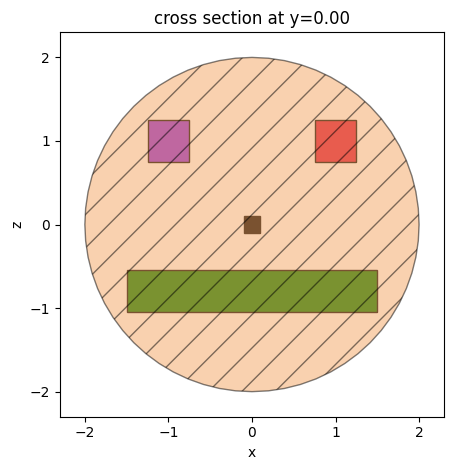

In [6]:
box1 = td.Box(center=(1.0, 0.0, 1), size=(0.5, 0.5, 0.5))
box2 = td.Box(center=(-1.0, 0.0, 1), size=(0.5, 0.5, 0.5))
box3 = td.Box(center=(0, 0.0, 0.0), size=(0.2, 0.2, 0.2))
box4 = td.Box(center=(0.0, 0.0, -0.8), size=(3, 0.5, 0.5))

ax = box1.plot(y=0, facecolor="crimson", edgecolor="black", alpha=1)
ax = box2.plot(y=0, ax=ax, facecolor="blueviolet", edgecolor="black", alpha=1)
ax = box3.plot(y=0, ax=ax, facecolor="black", edgecolor="black", alpha=1)
ax = box4.plot(y=0, ax=ax, facecolor="green", edgecolor="black", alpha=1)
ax = sphere.plot(
    y=0, ax=ax, facecolor="sandybrown", edgecolor="black", alpha=0.5, hatch="/"
)


### Simulations

We can plot all components contained in [Simulation](../_autosummary/tidy3d.Simulation.html) with the `Simulation.plot()` method.

Let's create a simulation with a source, monitor, and a bunch of randomly placed spheres made of 3 distinct [Medium](../_autosummary/tidy3d.Medium.html) objects.

In [7]:
from numpy.random import random

L = 5  # length of simulation on all sides


def rand():
    return L * (random() - 0.5)


# make random list of structures
structures = [
    td.Structure(
        geometry=td.Sphere(center=(rand(), rand(), rand()), radius=1),
        medium=td.Medium(permittivity=np.random.choice([2.0, 2.5, 3.0, 3.5, 4.0])),
    )
    for i in range(20)
]

source = td.UniformCurrentSource(
    center=(0, 0, -L / 3),
    size=(L, L / 2, 0),
    polarization="Ex",
    source_time=td.GaussianPulse(
        freq0=100e14,
        fwidth=10e14,
    ),
)

monitor = td.FieldMonitor(
    center=(-L / 4, 0, 0), size=(L / 2, L, 0), freqs=[1], name="fields"
)

# make simulation from structures
sim = td.Simulation(
    size=(L, L, L),
    grid_spec=td.GridSpec.auto(wavelength=4),
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(num_layers=10),
        y=td.Boundary.periodic(),
        z=td.Boundary.pml(num_layers=10),
    ),
    structures=structures,
    sources=[source],
    monitors=[monitor],
    run_time=1e-12,
)


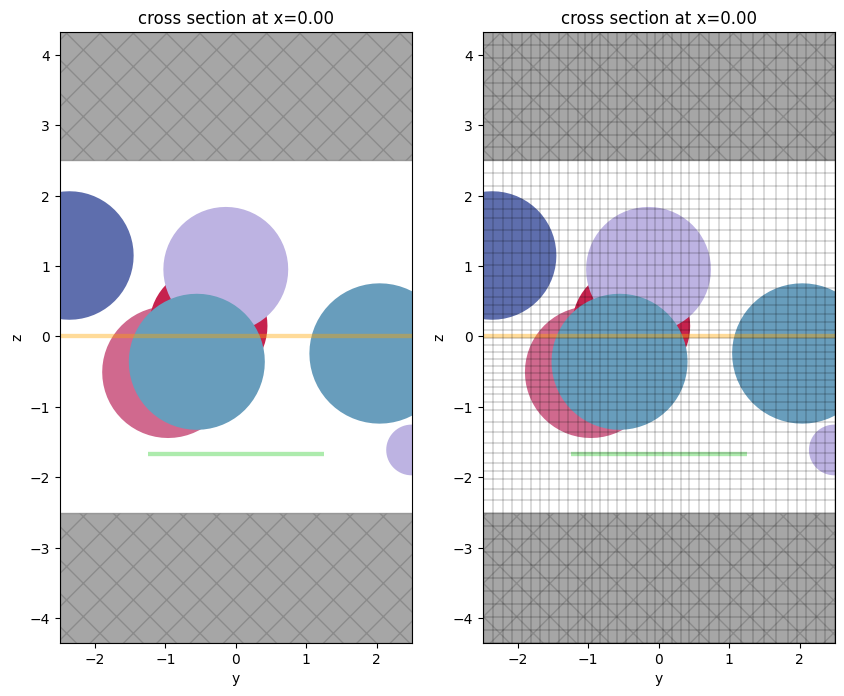

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1 = sim.plot(x=0, ax=ax1)

# put the grid lines on the 2nd one
ax2 = sim.plot(x=0, ax=ax2)
ax2 = sim.plot_grid(x=0, ax=ax2)


#### Plotting Materials

with `sim.plot` we can plot each distinct material, source, monitor, and PML.

Note, all structures with same [Medium](../_autosummary/tidy3d.Medium.html) show up as the same color.

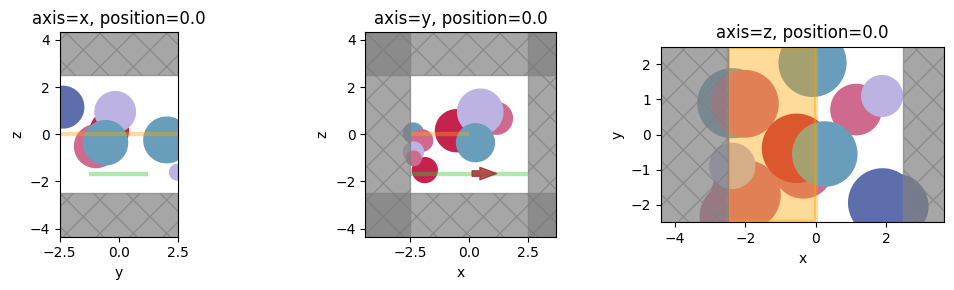

In [9]:
f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
for ax, axis in zip(axes, "xyz"):

    ax = sim.plot(**{axis: 0}, ax=ax)
    ax.set_title(f"axis={axis}, position=0.0")
plt.show()


We can even get fancy and plot the cross sections at different positions along the 3 axes.

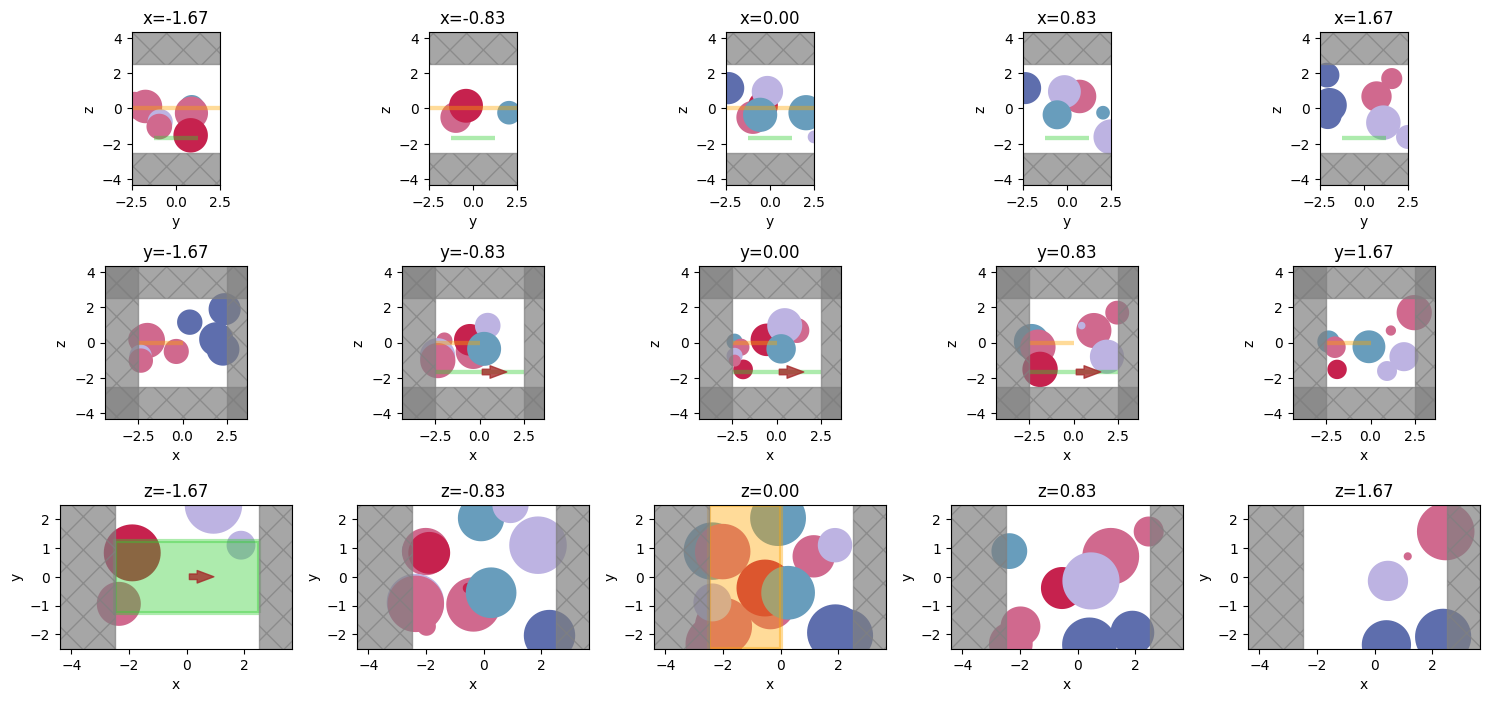

In [10]:
npos = 5
positions = np.linspace(-L / 3, L / 3, npos)
f, axes = plt.subplots(3, npos, tight_layout=True, figsize=(npos * 3, 7))
for axes_range, axis in zip(axes, "xyz"):
    for ax, pos in zip(axes_range, positions):
        ax = sim.plot(**{axis: pos}, ax=ax)
        ax.set_title(f"{axis}={pos:.2f}")
plt.show()


#### Plotting Permittivity

With `Simulation.plot_eps` we can plot the continuously varying permittivity distribution on the plane.

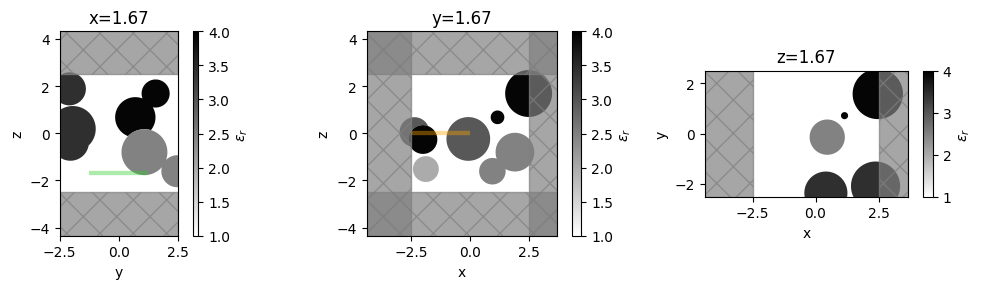

In [11]:
f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
for ax, axis in zip(axes, "xyz"):
    ax = sim.plot_eps(**{axis: pos}, ax=ax, alpha=0.98)
    ax.set_title(f"{axis}={pos:.2f}")
plt.show()


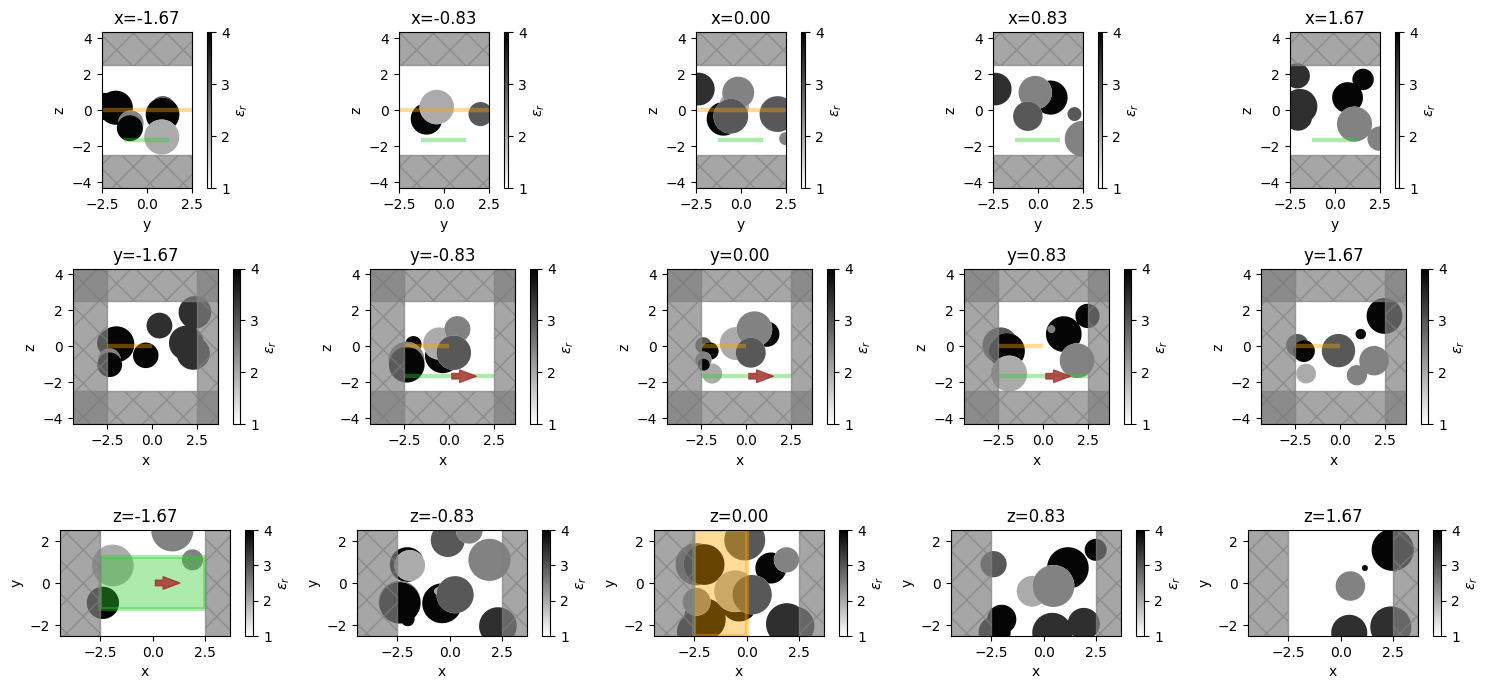

In [12]:
npos = 5
positions = np.linspace(-L / 3, L / 3, npos)
f, axes = plt.subplots(3, npos, tight_layout=True, figsize=(npos * 3, 7))
for axes_range, axis in zip(axes, "xyz"):
    for ax, pos in zip(axes_range, positions):
        ax = sim.plot_eps(**{axis: pos}, ax=ax, alpha=0.98)
        ax.set_title(f"{axis}={pos:.2f}")
plt.show()


## Plotting Other Quantities

### Structure + Medium

The `Structure.medium` refractive index values over frequency can be plotted with it's `.plot()` method as well.

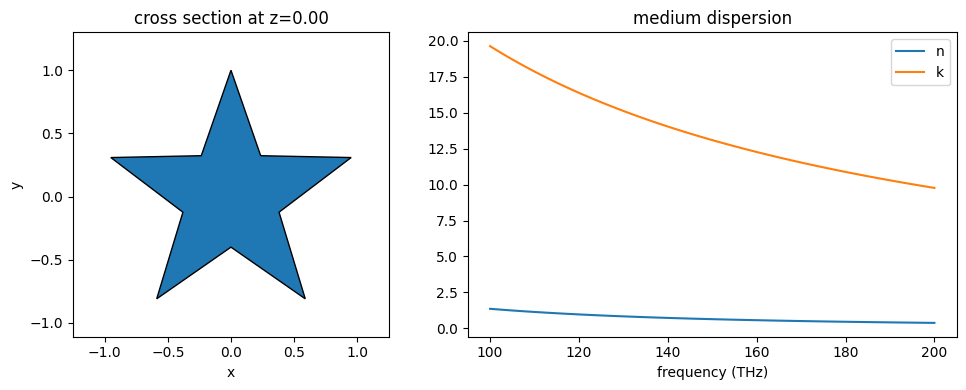

In [13]:
# import silver from material library
from tidy3d import material_library

Ag = material_library["Ag"]["Rakic1998BB"]

# make a star-shaped PolySlab
import numpy as np

r_in = 0.4
r_out = 1.0
inner_vertices = [
    (
        r_in * np.cos(2 * np.pi * i / 5 + np.pi / 2 - np.pi / 5),
        r_in * np.sin(2 * np.pi * i / 5 + np.pi / 2 - np.pi / 5),
    )
    for i in range(5)
]
outer_vertices = [
    (
        r_out * np.cos(2 * np.pi * i / 5 + np.pi / 2),
        r_out * np.sin(2 * np.pi * i / 5 + np.pi / 2),
    )
    for i in range(5)
]
star_vertices = []
for i in range(5):
    star_vertices.append(inner_vertices[i])
    star_vertices.append(outer_vertices[i])
poly_star = td.PolySlab(vertices=star_vertices, slab_bounds=(-1, 1), axis=2)

# make a star structure with silver as medium
silver_star = td.Structure(geometry=poly_star, medium=Ag)

# plot the structrue alongside the medium properties
freqs = np.linspace(1e14, 2e14, 101)
position = 0.0
axis = 2

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
ax1 = silver_star.geometry.plot(z=0, edgecolor="black", ax=ax1)
ax2 = silver_star.medium.plot(freqs=freqs, ax=ax2)


## Source + Source Time

Similarly, the `Source.source_time` amplitude over time can be plotted with its `.plot()` method.

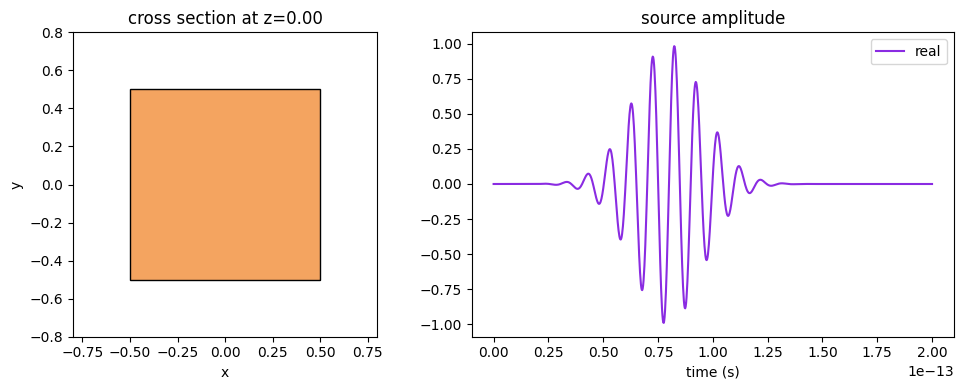

In [14]:
cube_source = td.UniformCurrentSource(
    center=(0, 0, 0),
    size=(1, 1, 1),
    polarization="Ex",
    source_time=td.GaussianPulse(
        freq0=1e14,
        fwidth=1e13,
    ),
)

times = np.linspace(0, 0.2e-12, 1001)
position = 0.0
axis = 2

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
ax1 = cube_source.geometry.plot(z=0, facecolor="sandybrown", edgecolor="black", ax=ax1)
ax2 = cube_source.source_time.plot(times=times, ax=ax2)


## Monitor

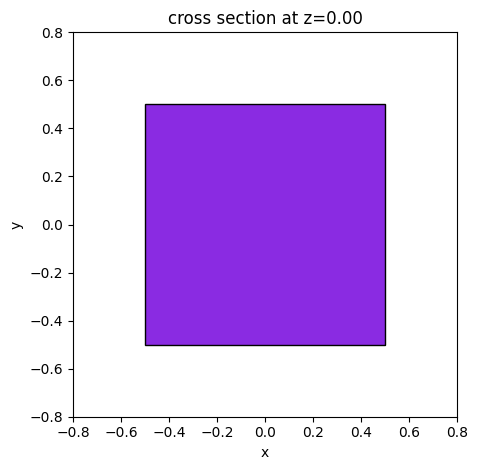

In [15]:
freq_mon = td.FieldMonitor(
    center=(0, 0, 0),
    size=(1, 1, 1),
    freqs=list(np.linspace(1e14, 2e14, 11)),
    name="test",
)

position = 0.0
axis = 2

ax = freq_mon.geometry.plot(z=0, facecolor="blueviolet", edgecolor="black")


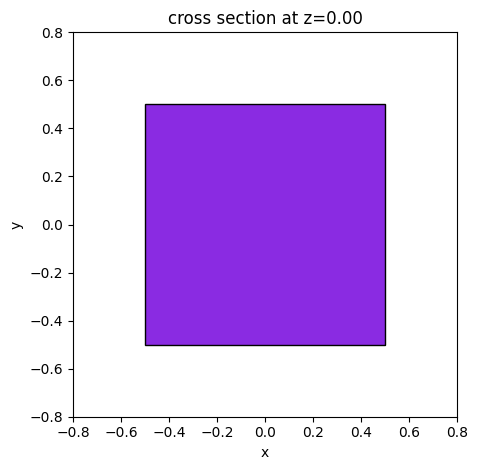

In [16]:
time_mon = td.FieldTimeMonitor(
    center=(0, 0, 0),
    size=(1, 1, 1),
    interval=10,
    name="test",
)

position = 0.0
axis = 2

ax = time_mon.geometry.plot(z=0, facecolor="blueviolet", edgecolor="black")
